In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import time
import os
import torch.nn.functional as F
from tqdm import tqdm
# new libraries
from data.data_loader import load_cifar10, load_cifar100, load_imagenet
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck
from torchvision.models.resnet import ResNet18_Weights, ResNet34_Weights

print(torch.cuda.is_available())
print(torch.cuda.device_count())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

True
1


In [2]:
# given parameters
learning_rate = 0.001
num_epochs = 5
num_workers = 2
batch_size = 100
temperature = 4.0
alpha = 0.9
momentum = 0.9
num_classes = 100
step_size = 20
gamma = 0.1

# new parameters
# lr_input = 0.1
# momentum_input = 0.9
weight_decay_input = 5e-4
# epochs = 20
T = 4.0 # temperatureture
# alpha = 0.9
patience = 5  # for early stopping

In [3]:
# Load CIFAR-100 dataset
trainloader, testloader  = load_cifar100()

Using downloaded and verified file: ./data/cifar-100-python.tar.gz
Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# Create instances of your models
teacher = torchvision.models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1).cuda()
teacher.eval()  # Set teacher model to evaluation mode
student = torchvision.models.resnet18(weights=None).cuda()

In [5]:
# Define optimizer and loss function
optimizer = optim.SGD(student.parameters(), lr=learning_rate, momentum=momentum)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

criterion = nn.CrossEntropyLoss()

In [6]:
# https://github.com/yushundong/RELIANT/blob/main/src/CPF-master/distill_dgl.py

def fair_metric(pred, labels, sens):
    sens = sens.cpu()
    labels = labels.cpu()
    idx_s0 = sens == 0
    idx_s1 = sens == 1
    idx_s0_y1 = idx_s0 & (labels == 1)
    idx_s1_y1 = idx_s1 & (labels == 1)

    if idx_s0.sum().item() == 0 or idx_s1.sum().item() == 0 or idx_s0_y1.sum().item() == 0 or idx_s1_y1.sum().item() == 0:
        return torch.tensor(0.0), torch.tensor(0.0)  # Return zeros

    parity = torch.abs((pred[idx_s0].sum() / (idx_s0.sum().item() + 1e-8)) - (pred[idx_s1].sum() / (idx_s1.sum().item() + 1e-8)))
    equality = torch.abs((pred[idx_s0_y1].sum() / (idx_s0_y1.sum().item() + 1e-8)) - (pred[idx_s1_y1].sum() / (idx_s1_y1.sum().item() + 1e-8)))

    return parity.item(), equality.item()

def approx_loss(logits, sens, idx):
    logits, sens, idx = logits.cpu(), sens.cpu(), idx.cpu()
    g1 = np.argwhere(sens.numpy() == 0.0).reshape(-1)
    g2 = np.argwhere(sens.numpy() == 1.0).reshape(-1)
    idx_set = set(idx.numpy())
    g1 = np.array(list(set(g1) & idx_set))
    g2 = np.array(list(set(g2) & idx_set))

    if g1.shape[0] == 0 or g2.shape[0] == 0:
        return torch.tensor(0.0)  # Return zero

    loss = torch.square(approx_func(logits[g1]).sum(axis=0) / (g1.shape[0]) - approx_func(logits[g2]).sum(axis=0) / (g2.shape[0])).sum()
    return loss

def approx_loss_eo(logits, sens, labels, idx):
    logits, sens, labels, idx = logits.cpu(), sens.cpu(), labels.cpu(), idx.cpu()
    g1 = np.argwhere(sens.numpy() == 0).reshape(-1)
    g2 = np.argwhere(sens.numpy() == 1).reshape(-1)
    g = np.argwhere(labels.numpy() == 1).reshape(-1)
    idx_set = set(idx.numpy())
    g1 = np.array(list(set(g1) & set(g) & idx_set))
    g2 = np.array(list(set(g2) & set(g) & idx_set))
    
    if g1.shape[0] == 0 or g2.shape[0] == 0:
        return torch.tensor(0.0)  # Return zero 

    loss = torch.square(approx_func(logits[g1]).sum(axis=0) / (g1.shape[0] + 1e-8) - approx_func(logits[g2]).sum(axis=0) / (g2.shape[0] + 1e-8)).sum()
    return loss

def approx_func(s):
    device = s.device  # Store the device information
    dtype = s.dtype    # Store the data type information
    s = s.detach().cpu().numpy()
    x = 2 * s - 1
    result = 1 / 2 + 1 / 2 * x - 1 / 8 / 2 * (5 * x * x * x - 3 * x) + 1 / 16 / 8 * (
                63 * x * x * x * x * x - 70 * x * x * x + 15 * x) - 5 / 128 / 16 * (
                       429 * x * x * x * x * x * x * x - 693 * x * x * x * x * x + 315 * x * x * x - 35 * x) + 7 / 256 / 128 * (
                       12155 * x * x * x * x * x * x * x * x * x - 25740 * x * x * x * x * x * x * x + 18018 * x * x * x * x * x - 4620 * x * x * x + 315 * x)
    return torch.tensor(result, device=device, dtype=dtype)


In [7]:
def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    inputs, _ = next(iter(dataloader))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time

def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for inputs, labels in dataloader:
        with torch.no_grad():
            teacher_outputs = teacher(inputs.to(device))
            student_outputs = student(inputs.to(device))
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(torch.argmax(teacher_outputs, dim=1).cpu().numpy())
        all_student_preds.append(torch.argmax(student_outputs, dim=1).cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),  # Updated line
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    
    return metrics

def compare_fairness_metrics(teacher, student, dataloader):
    teacher.to(device)  # Ensure the teacher model is on the same device as the inputs
    student.to(device)  # Ensure the student model is on the same device as the inputs
    
    teacher_fairness_metrics = {'parity': [], 'equality': []}
    student_fairness_metrics = {'parity': [], 'equality': []}

    for inputs, labels in dataloader:
        sensitive_attrs = labels  # Assuming label itself as a sensitive attribute
        with torch.no_grad():
            teacher_outputs = teacher(inputs.to(device))
            student_outputs = student(inputs.to(device))
        teacher_parity, teacher_equality = fair_metric(teacher_outputs, labels, sensitive_attrs)
        student_parity, student_equality = fair_metric(student_outputs, labels, sensitive_attrs)
        
        teacher_fairness_metrics['parity'].append(teacher_parity)
        teacher_fairness_metrics['equality'].append(teacher_equality)
        student_fairness_metrics['parity'].append(student_parity)
        student_fairness_metrics['equality'].append(student_equality)

    # Computing the average for each metric
    teacher_avg_fairness = {key: sum(values)/len(values) for key, values in teacher_fairness_metrics.items()}
    student_avg_fairness = {key: sum(values)/len(values) for key, values in student_fairness_metrics.items()}
    
    return teacher_avg_fairness, student_avg_fairness

# Then, when you call this function:
teacher_fairness_metrics, student_fairness_metrics = compare_fairness_metrics(teacher, student, trainloader)



def plot_comparison(labels, teacher_values, student_values, title, ylabel):
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, teacher_values, width, label='Teacher')
    rects2 = ax.bar(x + width/2, student_values, width, label='Student')

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()

    plt.show()

In [8]:
def adversarial_train_model(model, dataloader, criterion, optimizer, epoch, loss_log, combined_loss_log, fairness_penalty_sp_log, fairness_penalty_eo_log, fairness_penalty_approx_log, fairness_penalty_approx_eo_log, epoch_loss_log, epoch_combined_loss_log, epoch_fairness_penalty_sp_log, epoch_fairness_penalty_eo_log, epoch_fairness_penalty_approx_log, epoch_fairness_penalty_approx_eo_log):
    model.to(device)
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(enumerate(dataloader, 0), total=len(dataloader), unit="batch")
    for i, data in progress_bar:
        inputs, labels = data
        sensitive_attrs = labels  # Assuming label itself as a sensitive attribute
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        # Incorporate fairness metrics
        fairness_penalty_sp, fairness_penalty_eo = fair_metric(outputs, labels, sensitive_attrs)
        fairness_penalty_approx = approx_loss(outputs, sensitive_attrs, torch.arange(len(labels)).to(device))
        fairness_penalty_approx_eo = approx_loss_eo(outputs, sensitive_attrs, labels, torch.arange(len(labels)).to(device))
        combined_loss = loss + fairness_penalty_sp + fairness_penalty_eo + fairness_penalty_approx + fairness_penalty_approx_eo

        progress_bar.set_postfix(
            combined_loss=combined_loss.item(),
            fairness_penalty_sp=fairness_penalty_sp,
            fairness_penalty_eo=fairness_penalty_eo,
            fairness_penalty_approx=fairness_penalty_approx.item(),
            fairness_penalty_approx_eo=fairness_penalty_approx_eo.item()
        )
        combined_loss.backward()
        optimizer.step()
        running_loss += combined_loss.item()
        progress_bar.set_description(f"Epoch {epoch} Loss: {running_loss/(i+1):.4f}")
        
        # Logging the losses
        loss_log.append(loss.item())
        combined_loss_log.append(combined_loss.item())
        fairness_penalty_sp_log.append(fairness_penalty_sp)
        fairness_penalty_eo_log.append(fairness_penalty_eo)
        fairness_penalty_approx_log.append(fairness_penalty_approx.item())
        fairness_penalty_approx_eo_log.append(fairness_penalty_approx_eo.item())

    # Print the loss components and total loss after each epoch
    print(f'Epoch {epoch + 1} Loss Components:')
    print(f'Total Loss: {running_loss / len(dataloader):.4f}')
    print(f'Cross-Entropy Loss: {sum(loss_log) / len(loss_log):.4f}')
    print(f'SP Fairness Penalty: {sum(fairness_penalty_sp_log) / len(fairness_penalty_sp_log):.4f}')
    print(f'EO Fairness Penalty: {sum(fairness_penalty_eo_log) / len(fairness_penalty_eo_log):.4f}')
    print(f'Approx Fairness Penalty: {sum(fairness_penalty_approx_log) / len(fairness_penalty_approx_log):.4f}')
    print(f'Approx EO Fairness Penalty: {sum(fairness_penalty_approx_eo_log) / len(fairness_penalty_approx_eo_log):.4f}')

    # Append the average loss values to the epoch logging lists
    epoch_loss_log.append(sum(loss_log) / len(loss_log))
    epoch_combined_loss_log.append(running_loss / len(dataloader))
    epoch_fairness_penalty_sp_log.append(sum(fairness_penalty_sp_log) / len(fairness_penalty_sp_log))
    epoch_fairness_penalty_eo_log.append(sum(fairness_penalty_eo_log) / len(fairness_penalty_eo_log))
    epoch_fairness_penalty_approx_log.append(sum(fairness_penalty_approx_log) / len(fairness_penalty_approx_log))
    epoch_fairness_penalty_approx_eo_log.append(sum(fairness_penalty_approx_eo_log) / len(fairness_penalty_approx_eo_log))

    return running_loss / len(dataloader)
    
# Define the logging lists at the beginning of your script or before the training loop
teacher_loss_log, teacher_combined_loss_log, teacher_fairness_penalty_sp_log, teacher_fairness_penalty_eo_log, teacher_fairness_penalty_approx_log, teacher_fairness_penalty_approx_eo_log = [], [], [], [], [], []
student_loss_log, student_combined_loss_log, student_fairness_penalty_sp_log, student_fairness_penalty_eo_log, student_fairness_penalty_approx_log, student_fairness_penalty_approx_eo_log = [], [], [], [], [], []

# Define the missing epoch logging lists
epoch_loss_log, epoch_combined_loss_log, epoch_fairness_penalty_sp_log, epoch_fairness_penalty_eo_log, epoch_fairness_penalty_approx_log, epoch_fairness_penalty_approx_eo_log = [], [], [], [], [], []

# Train your model with adversarial training
for epoch in range(num_epochs):
    adversarial_train_model(student, trainloader, criterion, optimizer, epoch, student_loss_log, student_combined_loss_log, student_fairness_penalty_sp_log, student_fairness_penalty_eo_log, student_fairness_penalty_approx_log, student_fairness_penalty_approx_eo_log, epoch_loss_log, epoch_combined_loss_log, epoch_fairness_penalty_sp_log, epoch_fairness_penalty_eo_log, epoch_fairness_penalty_approx_log, epoch_fairness_penalty_approx_eo_log)


Epoch 0 Loss: 1063600806324471664214016.0000: 100%|█| 782/782 [03:58<00:00,  3.28batch/s, combined_loss=4.12, fairness_penalty_approx=0, fairness_pena


Epoch 1 Loss Components:
Total Loss: 1063600806324471664214016.0000
Cross-Entropy Loss: 4.3609
SP Fairness Penalty: 0.0000
EO Fairness Penalty: 0.0000
Approx Fairness Penalty: 1063600806324471664214016.0000
Approx EO Fairness Penalty: 0.0000


Epoch 1 Loss: 13050598320786848142589952.0000: 100%|█| 782/782 [04:01<00:00,  3.24batch/s, combined_loss=3.19, fairness_penalty_approx=0, fairness_pen


Epoch 2 Loss Components:
Total Loss: 13050598320786848142589952.0000
Cross-Entropy Loss: 4.0015
SP Fairness Penalty: 0.0000
EO Fairness Penalty: 0.0000
Approx Fairness Penalty: 7057099563555659970510848.0000
Approx EO Fairness Penalty: 0.0000


Epoch 2 Loss: 14478693152486768167092224.0000: 100%|█| 782/782 [04:00<00:00,  3.26batch/s, combined_loss=3.34, fairness_penalty_approx=0, fairness_pen


Epoch 3 Loss Components:
Total Loss: 14478693152486768167092224.0000
Cross-Entropy Loss: 3.7981
SP Fairness Penalty: 0.0000
EO Fairness Penalty: 0.0000
Approx Fairness Penalty: 9530964093199362702704640.0000
Approx EO Fairness Penalty: 0.0000


Epoch 3 Loss: 101239935614379198657855488.0000: 100%|█| 782/782 [03:56<00:00,  3.30batch/s, combined_loss=2.69, fairness_penalty_approx=0, fairness_pe


Epoch 4 Loss Components:
Total Loss: 101239935614379198657855488.0000
Cross-Entropy Loss: 3.6440
SP Fairness Penalty: 0.0000
EO Fairness Penalty: 0.0000
Approx Fairness Penalty: 32458206973494323302105088.0000
Approx EO Fairness Penalty: 0.0000


Epoch 4 Loss: 143205892024191113559539712.0000: 100%|█| 782/782 [03:56<00:00,  3.30batch/s, combined_loss=3.19, fairness_penalty_approx=0, fairness_pe

Epoch 5 Loss Components:
Total Loss: 143205892024191113559539712.0000
Cross-Entropy Loss: 3.5118
SP Fairness Penalty: 0.0000
EO Fairness Penalty: 0.0000
Approx Fairness Penalty: 54607743983633686507552768.0000
Approx EO Fairness Penalty: 0.0000


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


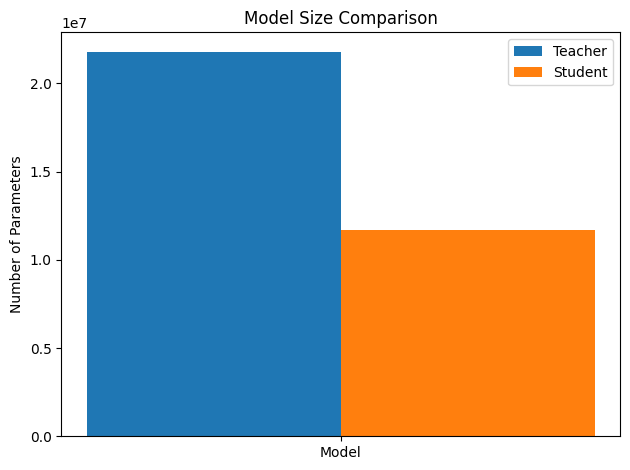

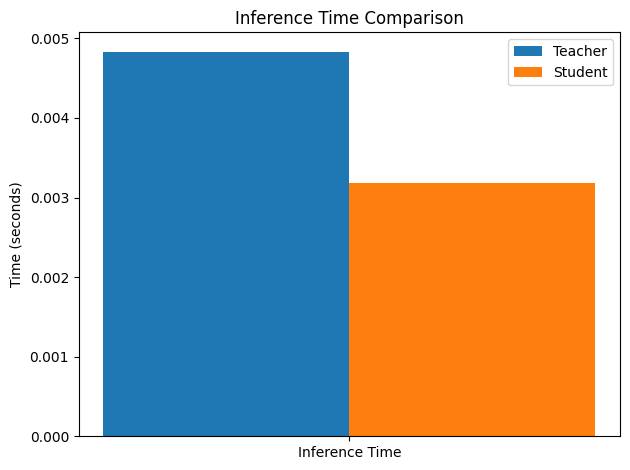

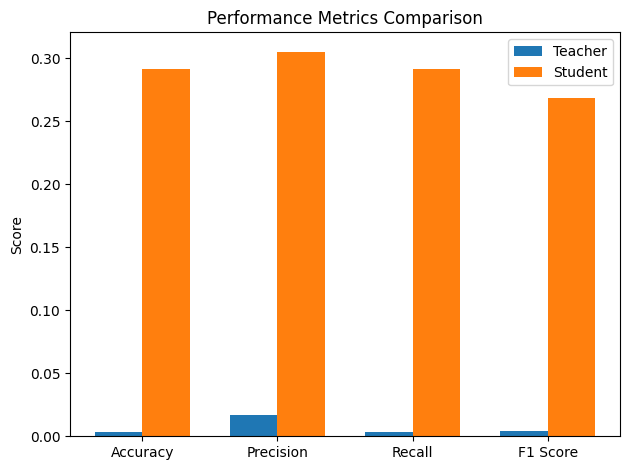

In [10]:
teacher_params, student_params = compare_model_size(teacher, student)
teacher_time, student_time = compare_inference_time(teacher, student, trainloader)
performance_metrics = compare_performance_metrics(teacher, student, trainloader)
teacher_fairness_metrics, student_fairness_metrics = compare_fairness_metrics(teacher, student, trainloader)

# Now plot the comparisons
plot_comparison(['Model'], [teacher_params], [student_params], 'Model Size Comparison', 'Number of Parameters')
plot_comparison(['Inference Time'], [teacher_time], [student_time], 'Inference Time Comparison', 'Time (seconds)')
plot_comparison(['Accuracy', 'Precision', 'Recall', 'F1 Score'], 
                [performance_metrics[key][0] for key in performance_metrics], 
                [performance_metrics[key][1] for key in performance_metrics], 
                'Performance Metrics Comparison', 
                'Score')

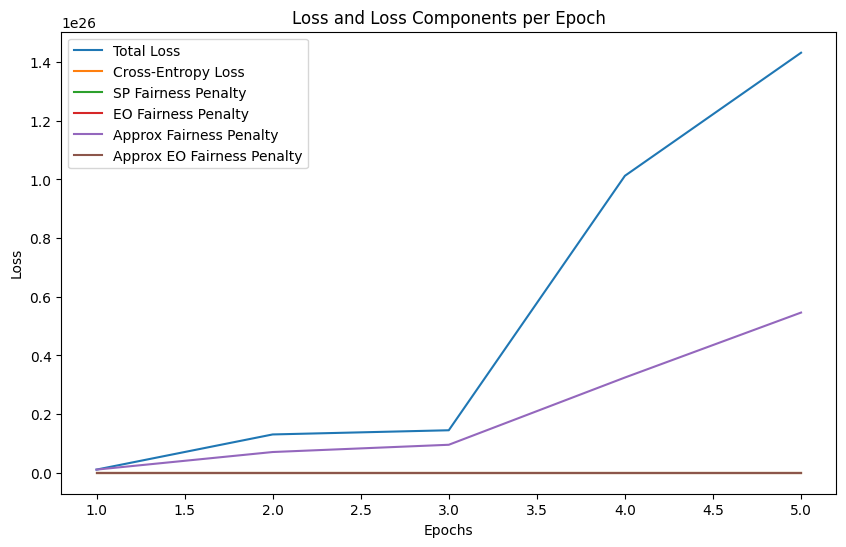

In [11]:
epochs = list(range(1, num_epochs + 1))  # Create a list of epoch numbers

plt.figure(figsize=(10, 6))
plt.plot(epochs, epoch_combined_loss_log, label='Total Loss')
plt.plot(epochs, epoch_loss_log, label='Cross-Entropy Loss')
plt.plot(epochs, epoch_fairness_penalty_sp_log, label='SP Fairness Penalty')
plt.plot(epochs, epoch_fairness_penalty_eo_log, label='EO Fairness Penalty')
plt.plot(epochs, epoch_fairness_penalty_approx_log, label='Approx Fairness Penalty')
plt.plot(epochs, epoch_fairness_penalty_approx_eo_log, label='Approx EO Fairness Penalty')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss and Loss Components per Epoch')
plt.show()

In [12]:
# Save the student model architecture and weights
torch.save(student.state_dict(), 'student_model.pth')
torch.save(teacher.state_dict(), 'teacher_model.pth')

# Define your model architectures as strings
teacher_arch = '''
class TeacherCNN(nn.Module):
    def __init__(self, num_classes=100):
        super(TeacherCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=2048, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=512)
        self.fc4 = nn.Linear(in_features=512, out_features=num_classes)
        
    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        x = nn.ReLU()(self.conv2(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        x = nn.ReLU()(self.conv3(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        x = x.view(x.size(0), -1)
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        x = nn.ReLU()(self.fc3(x))
        x = self.fc4(x)
        return x
'''

student_arch = '''
class StudentCNN(nn.Module):
    def __init__(self, num_classes=100):
        super(StudentCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(in_features=3600, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x
'''

# Open model_arch.py in write mode
with open('model_arch.py', 'w') as file:
    # Write the model architectures to model_arch.py
    file.write(teacher_arch)
    file.write(student_arch)
